## Activation Maximization on MNIST


https://github.com/raghakot/keras-vis/blob/master/examples/mnist/activation_maximization.ipynb

In [2]:
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv2D, MaxPooling2D
from keras import backend as k

In [3]:
batch_size = 128
num_classes = 10
epochs = 1

#input dimensiuni imagini
img_rows, img_cols = 28,28

#incaraca baza de date, amestecale si impartele intre instruire si testare
(x_train, y_train), (x_test, y_test)= mnist.load_data()

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0],1, img_rows, img_cols)
    x_test =x_test.reshape(x_test.shape[0],1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0],  img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#covert detat type si normalizeaza 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255 

#convert vectori de calsa in matrice de clase binare
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#crearea modelului
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', name='preds'))

#Comple modelul
model.compile(keras.optimizers.Adam(),keras.losses.categorical_crossentropy,['accuracy'])

#fit modelul
model.fit(x_train,y_train,
batch_size=batch_size,
epochs=epochs,
verbose=1,
validation_data=(x_test,y_test))

score = model.evaluate(x_test,y_test, verbose=0)
print('Test loss', score[0])
print('Test accuracy', score[1])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 14s 237us/step - loss: 0.2363 - accuracy: 0.9281 - val_loss: 0.0518 - val_accuracy: 0.9829
Test loss 0.05184926007355098
Test accuracy 0.9829000234603882


Vizualizări Saliency

Pentru a vizualiza activarea peste ieșirile de strat dens dens, trebuie să comutăm activarea softmax în linie, deoarece gradientul nodului de ieșire va depinde de toate celelalte activări ale nodului. A face acest lucru în keras este dificil, așa că oferim utils.apply_modifications pentru a modifica parametrii rețelei și a reconstrui graficul.

Dacă această schimbare nu se face, rezultatele ar putea fi suboptimale. Vom începe prin a schimba „softmax” pentru „liniar” și vom compara ce se întâmplă dacă nu facem acest lucru la sfârșit.

Vă permite să alegeți o intrare peste care dorim să arătăm atenția

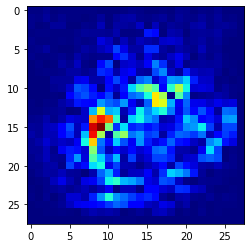

In [4]:
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
from matplotlib import pyplot as plt

class_idx = 0
indices = np.where(y_test[:, class_idx] ==1.)[0]

#alege aici o intrare aleatorie.
idx = indices[0]

#Utilitate pentru a căuta indexul stratului după nume.
# În mod alternativ, putem specifica acest lucru ca -1 deoarece corespunde ultimului strat.
layer_idx = utils.find_layer_idx(model, 'preds')

#Schimba softmax cu liniar
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx])

#Diagrama cu colormap „jet” pentru a fi vizualizată ca o hartă de căldură.
plt.imshow(grads,cmap='jet')



Pentru a utiliza guided saliency, trebuie să setăm backprop_modifier = 'guided'. Pentru rectified saliency or deconv saliency, utilizați backprop_modifier = 'relu'. Permiteți să încercați rapid aceste opțiuni și să vedeți cum se compară cu vanilla saliency.

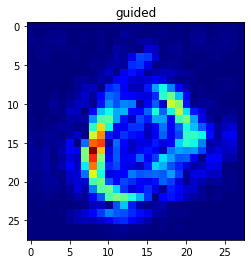

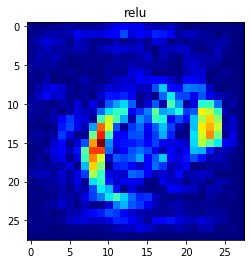

In [5]:
for modifier in ['guided', 'relu']:
    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                               seed_input=x_test[idx],backprop_modifier=modifier)
    plt.figure()
    plt.title(modifier)
    plt.imshow(grads, cmap='jet')








Amândouă arată mult mai bine decât vanilla saliency! Acest lucru este aliniat cu observația din lucrare.

De asemenea, putem vizualiza gradienți negativi pentru a vedea părțile imaginii care contribuie negativ la ieșire folosind grad_modifier = 'negate'.

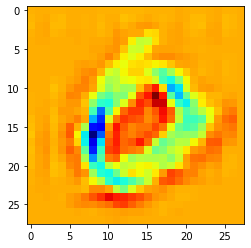

In [6]:
grads = visualize_saliency(model, layer_idx,filter_indices=class_idx,seed_input=x_test[idx],backprop_modifier='guided',grad_modifier='negate')
plt.imshow(grads, cmap='jet')

Permiteți să încercați toate clasele și să afișați intrări originale și hărțile de căldură una lângă alta. Nu putem suprapune harta de căldură pe imaginea originală de la scala de gri.

Vom compara, de asemenea, rezultatele guided and rectified or deconv saliency.

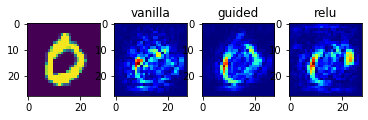

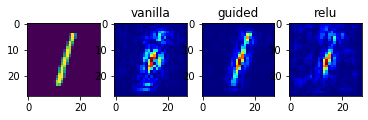

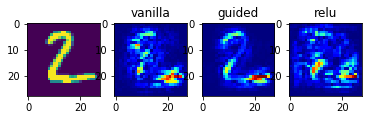

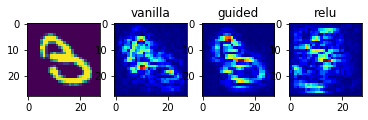

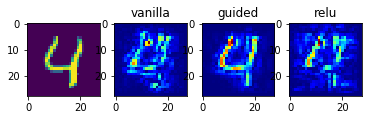

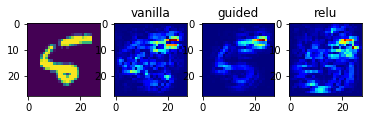

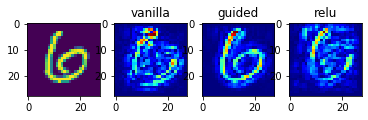

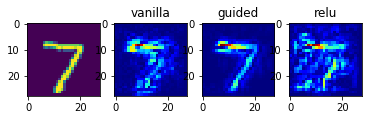

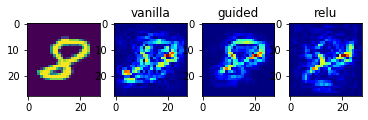

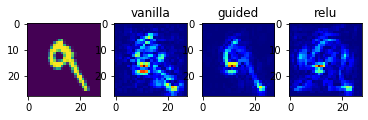

In [7]:
# Acest lucru corespunde stratului liniar dens.
for class_idx in np.arange(10):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])

    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx,
                                   seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)
        ax[i+1].imshow(grads, cmap='jet')
        


## grad-CAM - vanilla, guided, rectified

Acestea ar trebui să conțină mai multe detalii, deoarece folosesc funcțiile Conv sau Pooling care conțin mai multe detalii spațiale care se pierd în straturile dense. Singurul detaliu suplimentar în comparație cu saliency este penultimate_layer_idx. Acest lucru specifică pre-stratul ai cărui gradienți trebuie folosiți. Vezi această lucrare pentru detalii tehnice: https://arxiv.org/pdf/1610.02391v1.pdf

În mod implicit, dacă penultimate_layer_idx nu este definit, acesta caută cel mai apropiat strat pre. Pentru arhitectura noastră, acesta ar fi stratul MaxPooling2D după toate straturile Conv. Să ne uităm la toate vizualizările ca înainte.



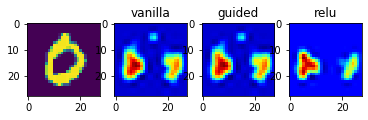

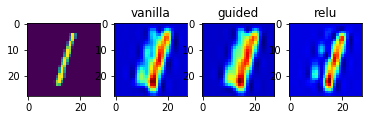

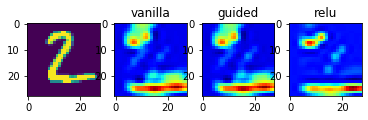

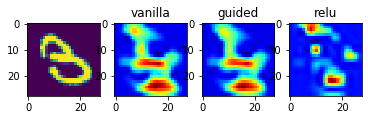

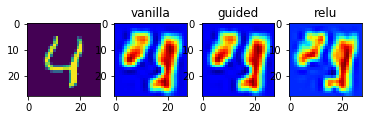

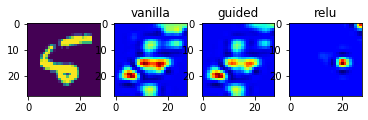

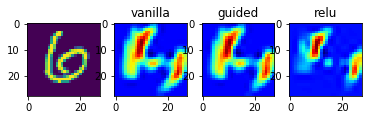

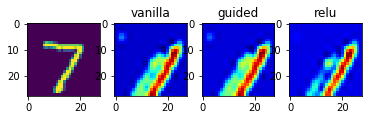

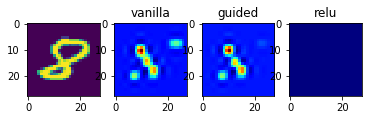

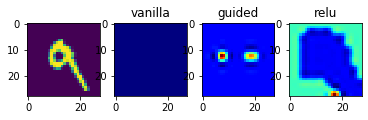

In [8]:
from vis.visualization import visualize_cam

#Aceasta corespunde stratului liniar dens.
for class_idx in np.arange(10):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1,4)
    ax[0].imshow(x_test[idx][..., 0])

    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_cam(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx],backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)
        ax[i+1].imshow(grads, cmap='jet')
   


În acest caz, saliency pare să fie mai bună decât grad-CAM, deoarece penultimul strat MaxPooling2D are (12, 12) rezoluție spațială, care este relativ mare în comparație cu intrarea de (28, 28). Este probabil că stratul conv nu a capturat suficientă informație la nivel înalt și cea mai mare parte este probabil în stratul dens_4.

Iată rezumatul modelului de referință.


In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [ ]:
##Vizualizare fără a schimba softmax

Așa cum s-a făcut aluzie la începutul tutorialului, dorim să comparăm și să vedem ce se întâmplă dacă nu făceam schimb intre softmax si linear activare  Permiteți să încercați acest lucru cu guided saliency, care ne-a dat cele mai bune rezultate până acum.

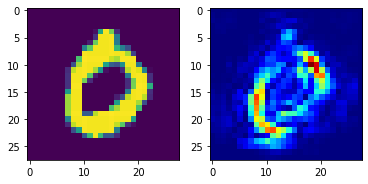

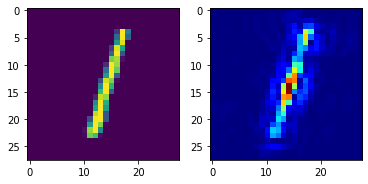

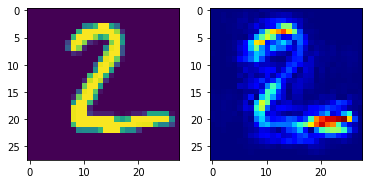

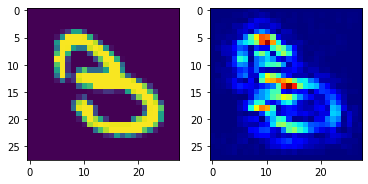

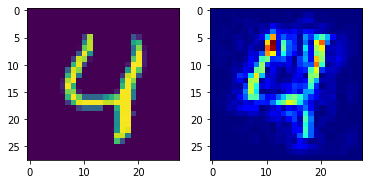

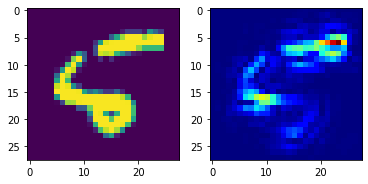

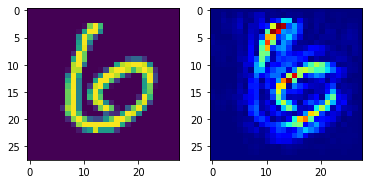

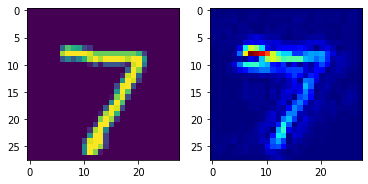

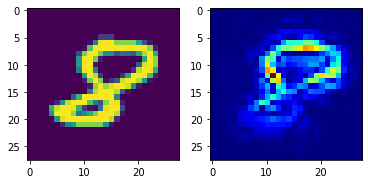

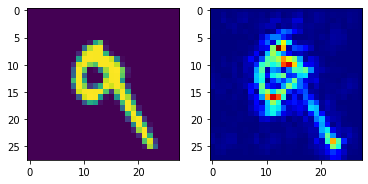

In [10]:
#Scimba liniaritatea inapoi cu softmax
model.layers[layer_idx].activation = activations.softmax
model = utils.apply_modifications(model)

for class_idx in np.arange(10):
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=x_test[idx],backprop_modifier='guided')
    f,ax = plt.subplots(1,2)
    ax[0].imshow(x_test[idx][..., 0])
    ax[1].imshow(grads, cmap='jet')



  
Nu merge la fel de bine!

Motivul este că maximizarea unui nod de ieșire se poate face prin minimizarea altor ieșiri. Softmax este ciudat în acest fel. Este singura activare care depinde de alte ieșiri (noduri) din strat.




